# Demo - Numpyro

In [16]:
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

import pathlib
from typing import Dict, Optional, Tuple

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro import diagnostics, infer, optim
from numpyro.contrib.control_flow import scan
from numpyro.distributions import constraints
from numpyro.infer.svi import SVIRunResult


## Data

In [17]:
def _load_data(batch: int = 100) -> jnp.ndarray:

    x = jnp.concatenate(
        [
            np.random.randn(10, batch),
            np.random.randn(10, batch) + 2,
            np.random.randn(10, batch) - 1,
            np.random.randn(10, batch) + 1,
        ]
    )
    x = x + jnp.arange(len(x))[:, None] * 0.3
    x = x[..., None]

    return x

In [18]:
x = _load_data()
x.shape

(40, 100, 1)

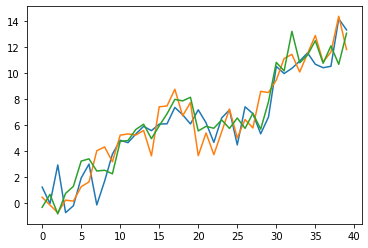

In [19]:
fig, ax = plt.subplots()

ax.plot(x[:, 0, :])
ax.plot(x[:, 1, :])
ax.plot(x[:, 2, :])
plt.show()

## Model

In [42]:
def model(
    x: Optional[jnp.ndarray] = None,
    seq_len: int = 0,
    batch: int = 0,
    x_dim: int = 1,
    future_steps: int = 0,
) -> None:
    """Simple Kalman filter model (random walk).
    Args:
        x: **Batch-second** data, `shape = (seq_len, batch, data_dim)`.
        seq_len: Length of sequence.
        batch: Batch size for prior sampling.
        x_dim: Dimension of data for prior sampling.
        future_steps: Forecasting time steps.
    """
    
    if x is not None:
        print("Input:", x.shape)
        z_init = x[0]
        seq_len, batch, x_dim = x.shape
    else:
        z_init = jnp.zeros((batch, x_dim))
    numpyro.deterministic("z_init", z_init)
    
    print("Init:", z_init.shape)

    trans_var = numpyro.param("trans_var", 0.01, constraint=constraints.positive)
    emit_mu = numpyro.param("emit_mu", 1.0)
    emit_var = numpyro.param("emit_var", 0.01, constraint=constraints.positive)
    coef = numpyro.param("coef", 1.0)

    def transition_fn(
        carry: Tuple[jnp.ndarray], t: jnp.ndarray
    ) -> Tuple[Tuple[jnp.ndarray], jnp.ndarray]:

        z_prev, *_ = carry
        print("z_prev:", z_prev.shape)
        z = numpyro.sample("z", dist.Normal(z_prev + coef * t, trans_var))
        x = numpyro.sample("x", dist.Normal(emit_mu * z, emit_var))
        print("Loop:", z_prev.shape, z.shape, x.shape)
        return (z,), None

    with numpyro.handlers.condition(data={"x": x}):
        scan(transition_fn, (z_init,), jnp.arange(seq_len + future_steps))

### Prior

In [43]:
%%time

rng_key = random.PRNGKey(0)
rng_key, rng_key_prior, rng_key_infer, rng_key_posterior = random.split(rng_key, 4)

print("Data:", x.shape)
# Prior prediction

predictive = infer.Predictive(model, num_samples=10)
print("No Input")
prior_predictive = predictive(rng_key_prior, None, *x.shape, future_steps=10)
print("Input")
prior_predictive = predictive(rng_key_prior, x, future_steps=10)


Data: (40, 100, 1)
No Input
Init: (100, 1)
z_prev: (100, 1)
Loop: (100, 1) (100, 1) (100, 1)
Input
Input: (40, 100, 1)
Init: (100, 1)
z_prev: (100, 1)
Loop: (100, 1) (100, 1) (100, 1)
CPU times: user 4.53 s, sys: 75.7 ms, total: 4.6 s
Wall time: 4.68 s


### Viz - 

### Guide (Approx Posterior)

In [32]:
def guide(
    x: Optional[jnp.ndarray] = None,
    seq_len: int = 0,
    batch: int = 0,
    x_dim: int = 1,
    future_steps: int = 0,
) -> None:

    if x is not None:
        *_, x_dim = x.shape

    phi = numpyro.param("phi", jnp.ones(x_dim))
    sigma = numpyro.param("sigma", jnp.ones(x_dim) * 0.05, constraint=constraints.positive)
    numpyro.sample("z", dist.Normal(x * phi, sigma))

## Training Loop

### Prior

In [33]:
x.shape

(40, 100, 1)

Init: (100, 1)
Loop: (100, 1) (100, 1) (100, 1)
Init: (100, 1)
Loop: (100, 1) (100, 1) (100, 1)
CPU times: user 4.44 s, sys: 25.4 ms, total: 4.47 s
Wall time: 4.47 s


#### Viz - 

In [8]:
len_train = x.shape[0]
x_pred_trn = prior_predictive["x"][:, :len_train, 0]
x_hpdi_trn = diagnostics.hpdi(x_pred_trn)[:, :, 0]
x_pred_tst = prior_predictive["x"][:, len_train:, 0]
x_hpdi_tst = diagnostics.hpdi(x_pred_tst)[:, :, 0]
len_test = x_pred_tst.shape[1]

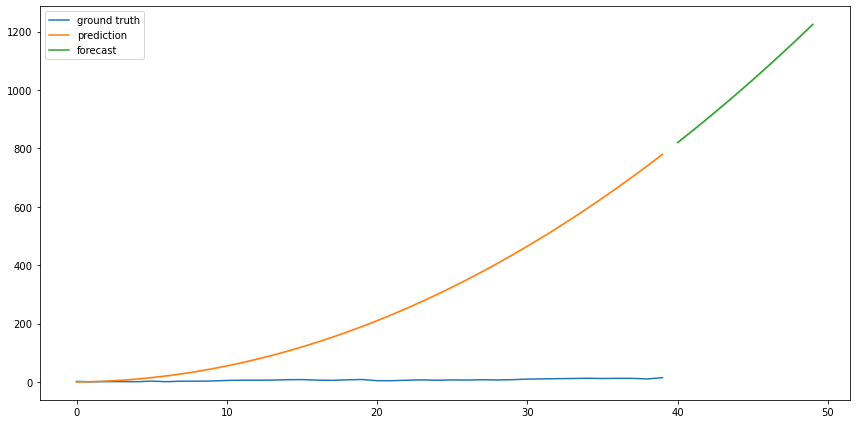

In [9]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

plt.figure(figsize=(12, 6))
plt.plot(x[:, 0].ravel(), label="ground truth", color=colors[0])

t_train = np.arange(len_train)
plt.plot(t_train, x_pred_trn.mean(0).ravel(), label="prediction", color=colors[1])
plt.fill_between(
    t_train, x_hpdi_trn[0].ravel(), x_hpdi_trn[1].ravel(), alpha=0.3, color=colors[1]
)

t_test = np.arange(len_train, len_train + len_test)
plt.plot(t_test, x_pred_tst.mean(0).ravel(), label="forecast", color=colors[2])
plt.fill_between(
    t_test, x_hpdi_tst[0].ravel(), x_hpdi_tst[1].ravel(), alpha=0.3, color=colors[2]
)

plt.legend()
plt.tight_layout()
# plt.savefig(root / "kalman.png")
plt.show()

### Inference

In [10]:
%%time
# optimizers
lr = 1e-4
adam = optim.Adam(lr)


n_epochs = 50_000

# Inference
svi = infer.SVI(model, guide, adam, infer.TraceMeanField_ELBO())
svi_result = svi.run(rng_key_infer, n_epochs, x)

100%|█| 50000/50000 [00:10<00:00, 4972.13it/s, init loss: 4914796298240.0000, av


CPU times: user 15.1 s, sys: 267 ms, total: 15.4 s
Wall time: 15.2 s


### Viz - Loss

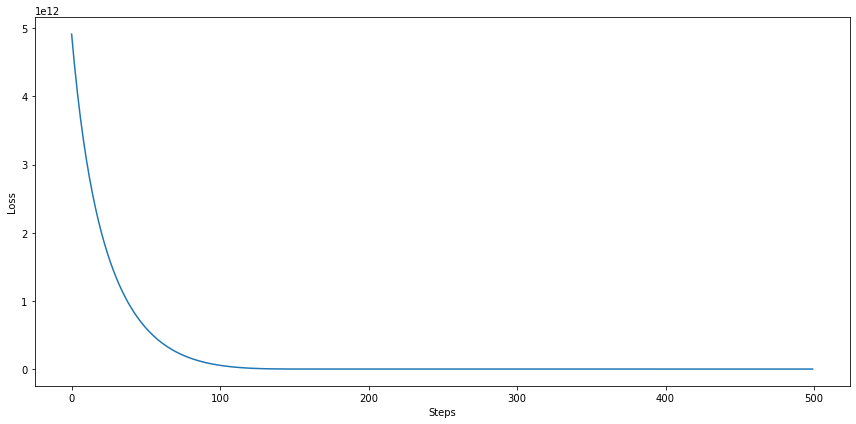

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(svi_result.losses[::100])
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.tight_layout()
# plt.savefig(root / "losses.png")
plt.show()

### Posterior Prediction

In [21]:
svi_result.params

{'coef': DeviceArray(0.01336, dtype=float32),
 'emit_mu': DeviceArray(1.3827027, dtype=float32),
 'emit_var': DeviceArray(0.16894418, dtype=float32),
 'phi': DeviceArray([0.6003316], dtype=float32),
 'sigma': DeviceArray([0.15665877], dtype=float32),
 'trans_var': DeviceArray(0.15665919, dtype=float32)}

In [12]:
%%time
# Posterior prediction
predictive = infer.Predictive(model, params=≈, num_samples=10)
posterior_predictive = predictive(rng_key_posterior, None, *x.shape, future_steps=10)

CPU times: user 2.91 s, sys: 38.3 ms, total: 2.95 s
Wall time: 2.82 s


## Results

In [13]:
len_train = x.shape[0]
x_pred_trn = posterior_predictive["x"][:, :len_train, 0]
x_hpdi_trn = diagnostics.hpdi(x_pred_trn)[:, :, 0]
x_pred_tst = posterior_predictive["x"][:, len_train:, 0]
x_hpdi_tst = diagnostics.hpdi(x_pred_tst)[:, :, 0]
len_test = x_pred_tst.shape[1]

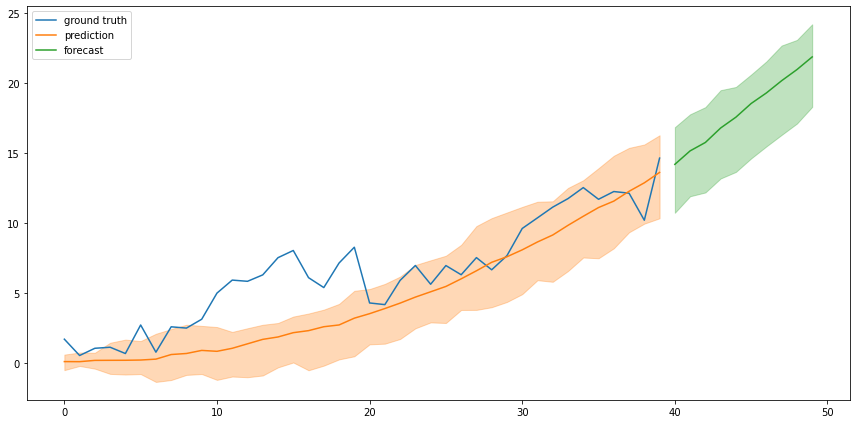

In [14]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

plt.figure(figsize=(12, 6))
plt.plot(x[:, 0].ravel(), label="ground truth", color=colors[0])

t_train = np.arange(len_train)
plt.plot(t_train, x_pred_trn.mean(0).ravel(), label="prediction", color=colors[1])
plt.fill_between(
    t_train, x_hpdi_trn[0].ravel(), x_hpdi_trn[1].ravel(), alpha=0.3, color=colors[1]
)

t_test = np.arange(len_train, len_train + len_test)
plt.plot(t_test, x_pred_tst.mean(0).ravel(), label="forecast", color=colors[2])
plt.fill_between(
    t_test, x_hpdi_tst[0].ravel(), x_hpdi_tst[1].ravel(), alpha=0.3, color=colors[2]
)

plt.legend()
plt.tight_layout()
# plt.savefig(root / "kalman.png")
plt.show()